In [1]:
import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.layers import merge,concatenate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("dat/ratings.dat",sep='::',names="user_id,item_id,rating,timestamp".split(","))

In [3]:
dataset.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(6040, 3706)

In [5]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [6]:
dataset.head()

,user_id,item_id,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291


In [7]:
train, test = train_test_split(dataset, test_size=0.2)

In [8]:
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

In [9]:
n_latent_factors_user = 10
n_latent_factors_movie = 15

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = concatenate([movie_vec, user_vec],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)

reshape = keras.layers.Reshape((25,1))(concat)
lstm = keras.layers.LSTM(64)(reshape)

dense = keras.layers.Dense(256,name='FullyConnected')(lstm)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(128,name='FullyConnected-1')(dense)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(64,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(32,name='FullyConnected-3', activation='relu')(dense_3)

result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 15)        55605       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        60410       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [11]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=15)

Epoch 1/15
800167/800167 [==============================] - 305s 381us/step - loss: 0.7419
Epoch 2/15
800167/800167 [==============================] - 313s 392us/step - loss: 0.6925
Epoch 3/15
800167/800167 [==============================] - 300s 375us/step - loss: 0.6812
Epoch 4/15
800167/800167 [==============================] - 299s 374us/step - loss: 0.6782
Epoch 5/15
800167/800167 [==============================] - 304s 380us/step - loss: 0.6735
Epoch 6/15
800167/800167 [==============================] - 303s 378us/step - loss: 0.6702
Epoch 7/15
800167/800167 [==============================] - 302s 378us/step - loss: 0.6757
Epoch 8/15
800167/800167 [==============================] - 302s 378us/step - loss: 0.6698
Epoch 9/15
800167/800167 [==============================] - 303s 379us/step - loss: 0.6701
Epoch 10/15
800167/800167 [==============================] - 303s 379us/step - loss: 0.6683
Epoch 11/15
800167/800167 [==============================] - 306s 383us/step - loss: 0.66

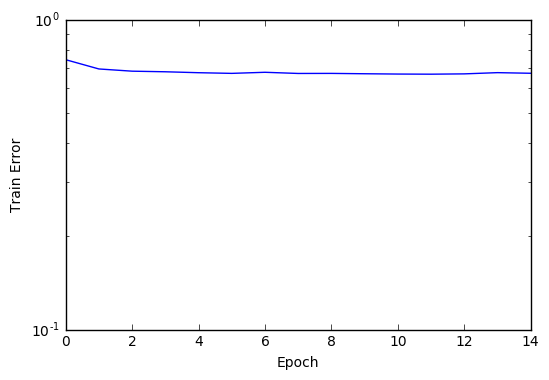

In [12]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [13]:
y_true_test = test.rating
y_true_train = train.rating
y_test = np.round(model.predict([test.user_id, test.item_id]),0)
y_train = np.round(model.predict([train.user_id, train.item_id]),0)

print(mean_absolute_error(y_true_test, y_test))
print(mean_absolute_error(y_true_train, y_train))

0.6797372551764129
0.6581238666428383


In [14]:
y_test = np.round(model.predict([test.user_id, test.item_id]),0)
y_train = np.round(model.predict([train.user_id, train.item_id]),0)

print(mean_squared_error(y_true_test, y_test))
print(mean_squared_error(y_true_train, y_train))

0.9276651903100349
0.8914976498655905
